# 3. Training a machine learning classifier to distinguish between bound and unbound sites
GB Shape: http://rohsdb.cmb.usc.edu/
"Predicted structural properties for every human genome positions are available here"

## 3-1. Data-Preprocessing: 
## Mini-objective: Given an input, predict whether the site is bound or unbound
Assumption: All the input sequence is of length 20bp (length of a TBP binding site) and it should be bound

In [149]:
from Bio import SeqIO
from random import sample
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from collections import Counter

In [150]:
start_time_overall = time.time()

In [153]:
#### Looking at Position Weight Matrix (PWM) of TBP
tf = 'TBP'
dnashape_pos = "phpYwJDXp_pos"
dnashape_neg = "phpnRRPIR_neg"
zipname_pos = "phpYwJDX"
zipname_neg = "phpnRRPIR"

In [154]:
with open('factorbookMotifPwm.txt') as f:
    for line in f:
        if tf in line:
            line = line.split(",")
            for i in range(len(line)):
                if i == 0:
                    tf_name = line[i].split("\t")[0]
                    tf_len = line[i].split("\t")[1]
                    tf_len = int(tf_len)
                    print("tf_name:", tf_name)
                    print("tf_len:", tf_len)
                    line[i] = line[i].split("\t")[-1]
                else:
                    line[i] = line[i].replace("\t", "")
            del line[-1]
            #tf_name = line[0]
            print(tf_name)
            #print(line)
            print(len(line))
            line_int = [float(i) for i in line]
            # Convert to a numpy array
            pwm_arr = np.array(line_int)
            pwm_arr.astype(int)
            #print(pwm_arr)
            pwm_arr2 = np.reshape(pwm_arr, (4, tf_len))
            print(pwm_arr2)
            print(np.sum(pwm_arr2, axis=0))

tf_name: TBP
tf_len: 20
TBP
80
[[0.088608 0.189873 0.202532 0.139241 0.139241 0.189873 0.196203 0.113924
  0.082278 0.14557  0.044304 0.037975 0.126582 0.012658 0.316456 0.031646
  0.955696 0.056962 0.898734 0.170886]
 [0.563291 0.43038  0.316456 0.405063 0.35443  0.512658 0.411392 0.322785
  0.5      0.329114 0.417722 0.689873 0.170886 0.088608 0.       0.
  0.018987 0.006329 0.031646 0.234177]
 [0.227848 0.259494 0.360759 0.386076 0.424051 0.21519  0.246835 0.417722
  0.278481 0.35443  0.443038 0.050633 0.       0.       0.       0.
  0.       0.       0.050633 0.525316]
 [0.120253 0.120253 0.120253 0.06962  0.082278 0.082278 0.14557  0.14557
  0.139241 0.170886 0.094937 0.221519 0.702532 0.898734 0.683544 0.968354
  0.025316 0.936709 0.018987 0.06962 ]]
[1.       1.       1.       1.       1.       0.999999 1.       1.000001
 1.       1.       1.000001 1.       1.       1.       1.       1.
 0.999999 1.       1.       0.999999]


In [155]:
print(pwm_arr2[0,1])
print(pwm_arr2)

0.189873
[[0.088608 0.189873 0.202532 0.139241 0.139241 0.189873 0.196203 0.113924
  0.082278 0.14557  0.044304 0.037975 0.126582 0.012658 0.316456 0.031646
  0.955696 0.056962 0.898734 0.170886]
 [0.563291 0.43038  0.316456 0.405063 0.35443  0.512658 0.411392 0.322785
  0.5      0.329114 0.417722 0.689873 0.170886 0.088608 0.       0.
  0.018987 0.006329 0.031646 0.234177]
 [0.227848 0.259494 0.360759 0.386076 0.424051 0.21519  0.246835 0.417722
  0.278481 0.35443  0.443038 0.050633 0.       0.       0.       0.
  0.       0.       0.050633 0.525316]
 [0.120253 0.120253 0.120253 0.06962  0.082278 0.082278 0.14557  0.14557
  0.139241 0.170886 0.094937 0.221519 0.702532 0.898734 0.683544 0.968354
  0.025316 0.936709 0.018987 0.06962 ]]


#### Determination of threshold
* Already have: the actual sequences of positive examples
* From: these sequences (fasta file containing them)
* Calculate the average log probability of all the positive examples
* Use this average log probability as the threshold when identifying the unbound sites

In [156]:
list_chrs = ['chr%s' % s for s in range(1,23)]
list_chrs.append("chrX")
print(list_chrs)
print(len(list_chrs))

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
23


In [157]:
# Find the log probability threshold

max_logprob_all = 0
for chom in list_chrs:
    print("chom: ", chom)
    filename = "./ExtractedSeqs_" + tf + "/seqs_" + tf + "_fwd_pos/seqs_" + chom + "_" + tf + "_fwd_pos.fasta"
    sum_logprob = 0
    avg_logprob = 0
    max_logprob = 0

    n_seqs = len([len(rec) for rec in SeqIO.parse(filename, "fasta")])
    print("# of seqs: ", n_seqs)

    with open(filename, "r") as fh: #rU
        count = 0
        for seq_record in SeqIO.parse(fh, "fasta"):
            #print(seq_record.id)
            sequence = seq_record.seq
            #print(sequence)
            #print(sequence[12])
            target_seq = sequence
            k = 0
            log_prob = 0
            if target_seq[k+2] != "T" and target_seq[k+2] != "t" and target_seq[k+3] != "G" and target_seq[k+3] != "g" and target_seq[k+4] != "T" and target_seq[k+4] != "t" and target_seq[k+9] != "C" and target_seq[k+9] != "c" and target_seq[k+9] != "A" and target_seq[k+9] != "a":
                #print("Success")
                count += 1
                for i in range(20):
                    if target_seq[i] == 'A' or target_seq[i] == 'a':
                        arr_idx = 0
                    elif target_seq[i] == 'C' or target_seq[i] == 'c':
                        arr_idx = 1
                    elif target_seq[i] == 'G' or target_seq[i] == 'g':
                        arr_idx = 2
                    elif target_seq[i] == 'T' or target_seq[i] == 't':
                        arr_idx = 3
                    else: # if "N"
                        break
                    #print(i)
                    #print(arr_idx)
                    #print("PWM:", pwm_arr2[arr_idx, i])
                    log_prob += math.log(pwm_arr2[arr_idx, i])
                    #prob = prob * (pwm_arr2[arr_idx, j])
                    #print("===========")
                    #print("log_prob: ", log_prob)
                #print("log_prob2: ", log_prob)
                sum_logprob += log_prob
                if max_logprob > log_prob:
                    max_logprob = log_prob

            #print("count: ", count)
        #print("sum_logprob: ", sum_logprob)
        avg_logprob = sum_logprob / n_seqs
        print("count: ", count)
        print("avg_logprob: ", avg_logprob)
        print("max_logprob: ", max_logprob)        
        print("=============")
    if max_logprob_all > max_logprob:
        max_logprob_all = max_logprob
    print("max_logprob_all: ", max_logprob_all)
    logp_thresh = math.floor(max_logprob_all)

chom:  chr1
# of seqs:  29
count:  8
avg_logprob:  -5.383151466804802
max_logprob:  -21.0973227165288
max_logprob_all:  -21.0973227165288
chom:  chr2
# of seqs:  26
count:  5
avg_logprob:  -3.725741712881075
max_logprob:  -21.328758721894815
max_logprob_all:  -21.328758721894815
chom:  chr3
# of seqs:  20
count:  5
avg_logprob:  -4.706430258460941
max_logprob:  -19.971511456079035
max_logprob_all:  -21.328758721894815
chom:  chr4
# of seqs:  14
count:  2
avg_logprob:  -2.8620554715042905
max_logprob:  -21.14473226712874
max_logprob_all:  -21.328758721894815
chom:  chr5
# of seqs:  15
count:  3
avg_logprob:  -3.9182790007898642
max_logprob:  -21.195684381362636
max_logprob_all:  -21.328758721894815
chom:  chr6
# of seqs:  50
count:  8
avg_logprob:  -2.9044375994823075
max_logprob:  -20.12752208581302
max_logprob_all:  -21.328758721894815
chom:  chr7
# of seqs:  15
count:  5
avg_logprob:  -6.4961322276247015
max_logprob:  -21.708643588226888
max_logprob_all:  -21.708643588226888
chom:  c

In [158]:
print("log probability threshold:", logp_thresh)

log probability threshold: -22


##### Determination of threshold: Result
* E.g. for TBP: Based on the above code, it was observed that the maximum log probability was almost for all in the -21s (some in the -20s). Therefore, the student decided to set the threshold as -22.

#### Identification of unbound sequences

In [159]:
filename = "./ExtractedSeqs_" + tf + "/seqs_" + tf + "_fwd_neg/seqs_chr1_" + tf + "_fwd_neg.fasta"
n_seqs = len([len(rec) for rec in SeqIO.parse(filename, "fasta")])
print("# of sequences contained in the fasta:", n_seqs)

# of sequences contained in the fasta: 324


To save computational time, I will make the unbound sequence under the assumption that each region in the bedfile contains one binding site for TBP

In [161]:
s_time = time.time()
fileout = "./ExtractedSeqs_" + tf + "/seqs_" + tf + "_fwd_neg/unbound/seqs_" + tf + "_fwd_neg_unbound.fasta"
for chom in list_chrs:
    print("chom: ", chom)
    filename = "./ExtractedSeqs_" + tf + "/seqs_" + tf + "_fwd_neg/seqs_" + chom + "_" + tf + "_fwd_neg.fasta"
    #logp_thresh = -22
    
    with open(filename, "r") as fh:
        with open(fileout, "a") as fout:
            for seq_record in SeqIO.parse(fh, "fasta"):
                sequence = seq_record.seq
                #print(sequence)
                start_time = time.time()
                #print("length of the seq:", len(sequence))
                count2 = 0
                for j in range(len(sequence)-20):
                    #print("j:", j)
                    count += 1
                    target_seq = sequence[j:j+20]
                    if "N" in target_seq:
                        N_in = "YesN"
                    else:
                        N_in = "NoN"
                    if N_in == "NoN":
                        if target_seq[k+12] != "G" and target_seq[k+12] != "g" and target_seq[k+13] != "G" and target_seq[k+13] != "g" and target_seq[k+14] != "G" and target_seq[k+14] != "g" and target_seq[k+14] != "C" and target_seq[k+14] != "c" and target_seq[k+15] != "G" and target_seq[k+15] != "g" and target_seq[k+15] != "C" and target_seq[k+15] != "c" and target_seq[k+16] != "G" and target_seq[k+16] != "g" and target_seq[k+17] != "G" and target_seq[k+17] != "g":
                        #if target_seq[k+2] != "T" and target_seq[k+2] != "t" and target_seq[k+3] != "G" and target_seq[k+3] != "g" and target_seq[k+4] != "T" and target_seq[k+4] != "t" and target_seq[k+9] != "C" and target_seq[k+9] != "c" and target_seq[k+9] != "A" and target_seq[k+9] != "a":
                            log_prob = 0
                            for i in range(20):
                                if target_seq[i] == 'A' or target_seq[i] == 'a':
                                    arr_idx = 0
                                elif target_seq[i] == 'C' or target_seq[i] == 'c':
                                    arr_idx = 1
                                elif target_seq[i] == 'G' or target_seq[i] == 'g':
                                    arr_idx = 2
                                elif target_seq[i] == 'T' or target_seq[i] == 't':
                                    arr_idx = 3
                                else: # if "N"
                                    break

                                #print(pwm_arr2[arr_idx, i])
                                log_prob += math.log(pwm_arr2[arr_idx, i])
                            #print("log_prob:", log_prob)
                            if log_prob > logp_thresh: # if sum_logprob > -22
                                #print("Written")
                                #print(target_seq)
                                #print(type(str(target_seq)))
                                fout.write(str(target_seq)+"\n")
                                #SeqIO.write(target_seq, fout, "fasta") 
                                #count2 += 1
                                #print(count2)

                #print("count:", count)
                end_time = time.time()
                time_taken = end_time - start_time
                #print("run time:", time_taken)
e_time = time.time()
r_time = e_time - s_time
print("Running time of grid search to identify negative examples:", r_time)

chom:  chr1
chom:  chr2
chom:  chr3
chom:  chr4
chom:  chr5
chom:  chr6
chom:  chr7
chom:  chr8
chom:  chr9
chom:  chr10
chom:  chr11
chom:  chr12
chom:  chr13
chom:  chr14
chom:  chr15
chom:  chr16
chom:  chr17
chom:  chr18
chom:  chr19
chom:  chr20
chom:  chr21
chom:  chr22
chom:  chrX
Running time of grid search to identify negative examples: 50.111997842788696


In [52]:
filename = "./ExtractedSeqs/seqs_TBP_fwd_neg/seqs_chr1_TBP_fwd_neg.fasta"
n_seqs = len([len(rec) for rec in SeqIO.parse(filename, "fasta")])
print("# of sequences contained in the fasta:", n_seqs)
fileout = "seqs_chr1_TBP_fwd_neg_unbound.fasta"

with open(filename, "r") as fh:
    with open(fileout, "w") as fout:
        records = list(SeqIO.parse(fh, "fasta"))
        sample_seq = records[0].seq  # first record
        print(sample_seq)

FileNotFoundError: [Errno 2] No such file or directory: './ExtractedSeqs/seqs_TBP_fwd_neg/seqs_chr1_TBP_fwd_neg.fasta'

In [53]:
end_time_overall = time.time()
overall_run_time = end_time_overall - start_time_overall
print("Running time up until this point:", overall_run_time)

Running time up until this point: 131.36145496368408


## 3-1. Data-Preprocessing: 
## Mini-objective: Given an input, predict whether the site is bound or unbound
Assumption: All the input sequence is of length 20bp (length of a TBP binding site) and it should be bound

In [162]:
bad_words = ['>']
list_DNAprops = ["MGW", "HelT", "Roll", "ProT"]
print(list_DNAprops)

['MGW', 'HelT', 'Roll', 'ProT']


In [163]:
# Create textfiles that will later be converted to pandas dataframe
for prop in list_DNAprops:
    filein = "./ExtractedSeqs_" + tf + "/" + dnashape_neg +"/" + zipname_neg + "." + prop + ".txt"
    fileout = "./ExtractedSeqs_" + tf + "/" + dnashape_neg +"/" + zipname_neg + "_processed." + prop + ".txt"

    with open(filein) as oldfile, open(fileout, 'w') as newfile:
        n = 20
        list_header = [prop] * n
        #print(list_header)
        for j in range(n):
            list_header[j] = list_header[j] + str(j+1)
        header = ','.join(list_header)
        print(header)
        newfile.write(header)
        newfile.write("\n")
        for line in oldfile:
            if not any(bad_word in line for bad_word in bad_words):
                newfile.write(line)

FileNotFoundError: [Errno 2] No such file or directory: './ExtractedSeqs_TBP/phpnRRPIR_neg/phpnRRPIR.MGW.txt'

In [70]:
files_unbound = ["./ExtractedSeqs_" + tf + "/" + dnashape_neg +"/" + zipname_neg + "_processed." + prop + ".txt" for prop in list_DNAprops]
print(files_unbound)

['./ExtractedSeqs_UA7/phpOiEffH_neg/phpOiEffH_processed.MGW.txt', './ExtractedSeqs_UA7/phpOiEffH_neg/phpOiEffH_processed.HelT.txt', './ExtractedSeqs_UA7/phpOiEffH_neg/phpOiEffH_processed.Roll.txt', './ExtractedSeqs_UA7/phpOiEffH_neg/phpOiEffH_processed.ProT.txt']


In [71]:
for i in range(len(files_unbound)):
    if i == 0:
        print(files_unbound[i])
        df_properties_ub = pd.read_csv(files_unbound[i])
    
    else:
        print(files_unbound[i])
        df_property_ub = pd.read_csv(files_unbound[i])
        df_properties_ub = pd.concat([df_properties_ub, df_property_ub.reindex(df_properties_ub.index)], axis=1)

print(df_properties_ub.shape)
df_properties_ub["label"] = "unbound"
print(df_properties_ub.shape)

./ExtractedSeqs_UA7/phpOiEffH_neg/phpOiEffH_processed.MGW.txt
./ExtractedSeqs_UA7/phpOiEffH_neg/phpOiEffH_processed.HelT.txt
./ExtractedSeqs_UA7/phpOiEffH_neg/phpOiEffH_processed.Roll.txt
./ExtractedSeqs_UA7/phpOiEffH_neg/phpOiEffH_processed.ProT.txt
(3850, 80)
(3850, 81)


##### Repeat the procedure for bound sequences

In [72]:
# Create textfiles that will later be converted to pandas dataframe
for prop in list_DNAprops:
    filein = "./ExtractedSeqs_" + tf + "/" + dnashape_pos +"/" + zipname_pos + "." + prop + ".txt"
    fileout = "./ExtractedSeqs_" + tf + "/" + dnashape_pos +"/" + zipname_pos + "_processed." + prop + ".txt"

    with open(filein) as oldfile, open(fileout, 'w') as newfile:
        n = 20
        list_header = [prop] * n
        #print(list_header)
        for j in range(n):
            list_header[j] = list_header[j] + str(j+1)
        header = ','.join(list_header)
        print(header)
        newfile.write(header)
        newfile.write("\n")
        for line in oldfile:
            if not any(bad_word in line for bad_word in bad_words):
                newfile.write(line)

MGW1,MGW2,MGW3,MGW4,MGW5,MGW6,MGW7,MGW8,MGW9,MGW10,MGW11,MGW12,MGW13,MGW14,MGW15,MGW16,MGW17,MGW18,MGW19,MGW20
HelT1,HelT2,HelT3,HelT4,HelT5,HelT6,HelT7,HelT8,HelT9,HelT10,HelT11,HelT12,HelT13,HelT14,HelT15,HelT16,HelT17,HelT18,HelT19,HelT20
Roll1,Roll2,Roll3,Roll4,Roll5,Roll6,Roll7,Roll8,Roll9,Roll10,Roll11,Roll12,Roll13,Roll14,Roll15,Roll16,Roll17,Roll18,Roll19,Roll20
ProT1,ProT2,ProT3,ProT4,ProT5,ProT6,ProT7,ProT8,ProT9,ProT10,ProT11,ProT12,ProT13,ProT14,ProT15,ProT16,ProT17,ProT18,ProT19,ProT20


In [73]:
files_bound = ["./ExtractedSeqs_" + tf + "/" + dnashape_pos +"/" + zipname_pos + "_processed." + prop + ".txt" for prop in list_DNAprops]
print(files_bound)

['./ExtractedSeqs_UA7/phpKXASSB_pos/phpKXASSB_processed.MGW.txt', './ExtractedSeqs_UA7/phpKXASSB_pos/phpKXASSB_processed.HelT.txt', './ExtractedSeqs_UA7/phpKXASSB_pos/phpKXASSB_processed.Roll.txt', './ExtractedSeqs_UA7/phpKXASSB_pos/phpKXASSB_processed.ProT.txt']


In [132]:
for i in range(len(files_bound)):
    if i == 0:
        print(files_bound[i])
        df_properties_b = pd.read_csv(files_bound[i])    
    else:
        print(files_bound[i])
        df_property_b = pd.read_csv(files_bound[i])
        df_properties_b = pd.concat([df_properties_b, df_property_b.reindex(df_properties_b.index)], axis=1)

print(df_properties_b.shape)
df_properties_b["label"] = "bound"
print(df_properties_b.shape)

./ExtractedSeqs_UA7/phpKXASSB_pos/phpKXASSB_processed.MGW.txt
./ExtractedSeqs_UA7/phpKXASSB_pos/phpKXASSB_processed.HelT.txt
./ExtractedSeqs_UA7/phpKXASSB_pos/phpKXASSB_processed.Roll.txt
./ExtractedSeqs_UA7/phpKXASSB_pos/phpKXASSB_processed.ProT.txt
(2476, 80)
(2476, 81)


##### Merge the dataframes of bound and unbound sequences

In [75]:
df_properties_both = pd.concat([df_properties_ub, df_properties_b], axis=0)
print(df_properties_both.shape)
#print(df_properties_both.head(5))

(6326, 81)


##### Drop columns whose values are all NaN

In [76]:
df_properties_both = df_properties_both.dropna(how='all', axis=1)

### Implement a KNN classifier

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
import sklearn

In [140]:
df_shuffled = sklearn.utils.shuffle(df_properties_both)
n_rows = df_shuffled.shape[0]
n_cols = df_shuffled.shape[1]
print(n_rows)
print(n_cols)
#print(df_shuffled.shape)
df_nan = df_shuffled.dropna(axis=0, how = 'all')
df_nan = df_nan.dropna(thresh=n_rows*0.8, axis=1)
df_nan = df_nan.dropna(thresh=n_cols*0.8, axis=0)
df_nan = df_nan.dropna()
print(df_nan)
print(df_nan.shape)

6326
71
      MGW3  MGW4  MGW5  MGW6  MGW7  MGW8  MGW9  MGW10  MGW11  MGW12  ...  \
1220  4.63  4.36  4.03  4.63  5.18  5.54  5.51   5.08   4.69   4.73  ...   
3376  5.56  5.42  4.95  4.06  4.03  4.70  5.30   5.51   5.54   5.18  ...   
194   4.76  3.38  3.63  4.12  4.46  5.34  5.47   4.94   4.82   5.33  ...   
2037  5.31  4.92  4.65  4.73  4.45  4.29  4.85   5.47   5.56   4.89  ...   
1188  4.76  4.63  4.36  4.03  4.14  4.80  5.53   5.31   5.02   4.93  ...   
354   5.42  4.76  4.05  4.65  4.30  4.99  5.34   4.97   4.84   4.94  ...   
2333  4.74  4.36  4.03  4.17  4.61  4.95  5.19   5.36   4.96   4.72  ...   
2537  3.38  3.38  3.68  4.03  4.14  4.80  5.67   5.79   5.79   5.75  ...   
646   4.63  4.27  2.85  3.75  4.43  5.14  5.56   5.39   4.89   4.82  ...   
944   5.50  5.20  5.58  4.98  4.64  5.20  5.51   5.27   5.01   5.05  ...   
728   4.63  4.35  4.05  4.06  4.03  4.70  4.92   4.62   4.74   4.84  ...   
3176  5.56  5.42  4.52  4.03  4.14  4.80  5.67   5.41   5.17   5.37  ...   
157 

In [171]:
t_start = time.time()

X = df_nan.iloc[:,:-1]
y = df_nan.iloc[:,-1]

test_accuracy = []

best_accuracy = 0
best_n = 0

for i in range(1, 150):
    n = i  # number of neighbours i.e. hyperparameter of KNN
    k = 5
    kf = KFold(n_splits=k)
    knn1 = KNeighborsClassifier(n_neighbors=n)  # change n_neighbors as necessary

    acc_score = []
    for train_index, test_index in kf.split(X):
        #print(train_index, test_index)

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Feature scaling
        s = StandardScaler()
        s.fit(X_train)
        X_train = s.transform(X_train)
        X_test = s.transform(X_test)

        # Fit the model
        knn1.fit(X_train, y_train)
        pred_values = knn1.predict(X_test)

        accuracy = accuracy_score(pred_values, y_test)
        acc_score.append(accuracy)

    avg_acc_score = sum(acc_score) / k
    test_accuracy.append(avg_acc_score)
    
    if avg_acc_score > best_accuracy:
        best_accuracy = avg_acc_score
        best_n = n
        
    #print("Accuracy: each fold:", acc_score)
    print("Number of nearest neighbour:", n)
    print("Average accuracy:", avg_acc_score)
    print("best n:", best_n)
t_end = time.time()
t_total = t_end - t_start
print("Running time (s):", t_total)

Number of nearest neighbour: 150
Average accuracy: 0.8614944472419088
best n: 150
Number of nearest neighbour: 151
Average accuracy: 0.8614944472419088
best n: 150
Number of nearest neighbour: 152
Average accuracy: 0.8614944472419088
best n: 150
Number of nearest neighbour: 153
Average accuracy: 0.8614944472419088
best n: 150
Number of nearest neighbour: 154
Average accuracy: 0.8614944472419088
best n: 150
Number of nearest neighbour: 155
Average accuracy: 0.8614944472419088
best n: 150
Number of nearest neighbour: 156
Average accuracy: 0.8614944472419088
best n: 150
Number of nearest neighbour: 157
Average accuracy: 0.8614944472419088
best n: 150
Number of nearest neighbour: 158
Average accuracy: 0.8614944472419088
best n: 150
Number of nearest neighbour: 159
Average accuracy: 0.8614944472419088
best n: 150
Number of nearest neighbour: 160
Average accuracy: 0.8614944472419088
best n: 150
Number of nearest neighbour: 161
Average accuracy: 0.8614944472419088
best n: 150
Number of neares

Number of neighbours with the highest accuracy: 2
Highest accuracy achieved: 0.9252628572716957


Text(0, 0.5, 'Accuracy')

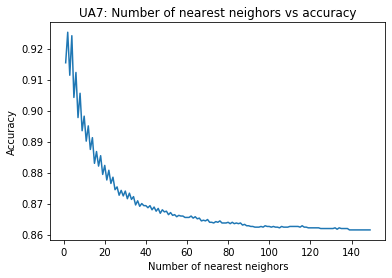

In [170]:
n_list = [i for i in range(1, 150)]
print("Number of neighbours with the highest accuracy:", best_n)
print("Highest accuracy achieved:", best_accuracy)
plt.plot(n_list, test_accuracy)
plt.title("UA7: Number of nearest neighors vs accuracy")
plt.xlabel("Number of nearest neighors")
plt.ylabel("Accuracy")

In [167]:
# Creating one KNN classifier
t_start = time.time()

X = df_nan.iloc[:,:-1]
y = df_nan.iloc[:,-1]


n_list = [i for i in range(1, 100)]
test_accuracy = []

best_accuracy = 0
best_n = 0

n = 2  # number of neighbours i.e. hyperparameter of KNN
k = 5
kf = KFold(n_splits=k)
knn1 = KNeighborsClassifier(n_neighbors=n)  # change n_neighbors as necessary

acc_score = []
for train_index, test_index in kf.split(X):
    #print(train_index, test_index)

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Feature scaling
    s = StandardScaler()
    s.fit(X_train)
    X_train = s.transform(X_train)
    X_test = s.transform(X_test)

    # Fit the model
    knn1.fit(X_train, y_train)
    pred_values = knn1.predict(X_test)

    accuracy = accuracy_score(pred_values, y_test)
    acc_score.append(accuracy)

avg_acc_score = sum(acc_score) / k
test_accuracy.append(avg_acc_score)

if avg_acc_score > best_accuracy:
    best_accuracy = avg_acc_score
    best_n = n

#print("Accuracy: each fold:", acc_score)
print("Number of nearest neighbour:", n)
print("Average accuracy:", avg_acc_score)
print("best n:", best_n)
t_end = time.time()
t_total = t_end - t_start
print("Running time (s):", t_total)

Number of nearest neighbour: 2
Average accuracy: 0.9252628572716957
best n: 2
Running time (s): 2.1782264709472656


### Implement a Logistic Regression classifier

In [147]:
from sklearn.linear_model import LogisticRegression

In [148]:
t_start2 = time.time()

X = df_nan.iloc[:,:-1]
y = df_nan.iloc[:,-1]


n_list = [i for i in range(1, 100)]
print(n)
test_accuracy = []

n = i  # number of neighbours i.e. hyperparameter of KNN
k = 5
kf = KFold(n_splits=k)
classifier = LogisticRegression(random_state=0, solver='liblinear')

acc_score = []
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    classifier.fit(X_train, y_train)
    pred_values = classifier.predict(X_test)

    accuracy = accuracy_score(pred_values, y_test)
    acc_score.append(accuracy)

avg_acc_score = sum(acc_score) / k
test_accuracy.append(avg_acc_score)

#print("Accuracy: each fold:", acc_score)
print("Average accuracy:", avg_acc_score)
t_end2 = time.time()
t_total2 = t_end2 - t_start2
print("Running time (s):", t_total2)

99
Average accuracy: 0.8713388497661404
Running time (s): 1.148926019668579


#### Perform a grid search to find the best model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('classifier', LogisticRegression())])
param_grid = [
    {'classifier': [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],  # L1 and L2 regularizations
     'classifier__C': np.logspace(-4, 4, 20),
     'classifier__solver': ['liblinear']
    }
]

# Create a grid search object
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
best_classifier = clf.fit(X_train, y_train)
print(best_classifier)